# Datasets and benchmarking

scikit-fingerprints hosts popular molecular datasets [on HuggingFace](https://huggingface.co/scikit-fingerprints), and implements functions to download them. We used them in previous tutorials. We also have a few other capabilities implemented for easy testing and benchmarking molecular models.

In this tutorial, we'll focus on [MoleculeNet benchmark](https://doi.org/10.1039/C7SC02664A), the most popular one in molecular property prediction. Other ones would work very similarly.

### Dataset loading functions

Functions for loading datasets are in submodules in `skfp.datasets` package. For example, `skfp.datasets.moleculenet` contains functions to load datasets from MoleculeNet.

By default, data is downloaded to the same locations as [scikit-learn datasets](https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.get_data_home.html), which can be set with `SCIKIT_LEARN_DATA` environment variable. By default, it is `scikit_learn_data` in the user home directory. This can be controlled per dataset with `data_dir` parameter. Datasets are downloaded and cached on first usage.

Functions return a tuple with list of SMILES strings and Numpy array with labels. If `as_frame` argument is True, they can alternatively return Pandas DataFrame with additional information, e.g. class names. This can be useful e.g. for multioutput datasets like [MUV](https://doi.org/10.1021/ci8002649).

Note that multioutput datasets may have missing labels. This is by design, since some values are unknown. After train-test split, you can fill the training labels if needed, e.g. with the most popular class. However, you **must not** touch labels for testing, and instead evaluate only on available labels. We will see in just a bit how to do that. Since NumPy does not support NaN values for integers, data type is `float`, even if only present values are really 0 or 1.

In [1]:
from skfp.datasets.moleculenet import load_bace

smiles_list, y = load_bace()
print(smiles_list[:5])
print(y[:5])

['O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', 'Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(=O)C)(CC(C)C)C1=O)CCc1ccccc1)[C@H](O)[C@@H]1[NH2+]C[C@H](OCCC)C1', 'S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(OC)ccc1)Cc1ccccc1)C', 'S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c(N)c(F)c2)[C@H](O)[C@@H]([NH2+]Cc2cc(ccc2)C(C)(C)C)C1', 'S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(ccc1)C(F)(F)F)Cc1ccccc1)C']
[1 1 1 1 1]


In [2]:
from skfp.datasets.moleculenet import load_tox21

smiles_list, y = load_tox21()
print(smiles_list[:5])
print(y[:5])

['CCOc1ccc2nc(S(N)(=O)=O)sc2c1', 'CCN1C(=O)NC(c2ccccc2)C1=O', 'CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]3CC[C@@]21C', 'CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C', 'CC(O)(P(=O)(O)O)P(=O)(O)O']
[[ 0.  0.  1. nan nan  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. nan  0. nan  0.  0.]
 [nan nan nan nan nan nan nan  0. nan  0. nan nan]
 [ 0.  0.  0.  0.  0.  0.  0. nan  0. nan  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [3]:
from skfp.datasets.moleculenet import load_tox21

df = load_tox21(as_frame=True)
df.head(5)

,SMILES,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Predefined splits

Some benchmarks provide predefined train-valid-test splits. For example, for MoleculeNet splits from [Open Graph Benchmark (OGB)](https://ogb.stanford.edu/) are often used. They use scaffold split, but due to some minor implementation differences the exact test set may be slightly different than one from the split you would do yourself. For fair comparison, you load the exact indexes with appropriate function.

In [4]:
from skfp.datasets.moleculenet import load_ogb_splits

train_idxs, valid_idxs, test_idxs = load_ogb_splits("SIDER")
train_idxs[:10]

[0, 4, 5, 6, 7, 9, 13, 14, 16, 17]

In [5]:
import numpy as np

smiles_arr = np.array(smiles_list)

# we won't tune hyperparameters, so we can safely add validation data
smiles_train = smiles_arr[train_idxs + valid_idxs]
y_train = y[train_idxs + valid_idxs]

smiles_test = smiles_arr[test_idxs]
y_test = y[test_idxs]

# fill missing training labels with zeros
y_train = np.nan_to_num(y_train, nan=0).astype(int)

print("Train:\n", y_train[:5])
print()
print("Test:\n", y_test[:5])

Train:
 [[0 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 1 0 1]]

Test:
 [[ 0.  0.  0.  0.  0.  0.  0. nan  0. nan  0.  0.]
 [nan nan nan nan nan nan nan  0. nan  0. nan nan]
 [ 0.  0.  0.  0.  0.  0.  0. nan  0. nan  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan  0.]
 [ 0.  0.  0. nan  0.  0.  0. nan  0. nan nan  0.]]


### Multioutput metrics

scikit-fingerprints implements [many quality metrics functions](https://scikit-fingerprints.readthedocs.io/latest/modules/metrics.html). They are made to be very versatile and robust, and work for single-task datasets, multioutput ones, and also when some labels are missing. For multitask datasets, basic metric is calculated separately for each task and averaged.

Probabilistic metrics like AUROC (Area Under Receiver Operating characteristic Curve) or AUPRC (Area Under Precision-Recall Curve) require predicted positive class probabilities as an input. Scikit-learn returns quite weird outputs in `.predict_proba()` for multioutput cases.  scikit-fingerprints implements `extract_pos_proba()` function to easily transform those outputs to probabilities with right shape.

If there are any problems with metrics calculation, warnings are printed by default. This can be suppressed with `suppress_warnings` parameter. It can be useful for running larger benchmarks with many multioutput datasets, where some folds or tasks are expected to fail.

Let's see an example, where we train a simple ECFP + Random Forest pipeline. RF in scikit-learn natively supports multioutput training.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from skfp.fingerprints import ECFPFingerprint
from skfp.metrics import extract_pos_proba, multioutput_auroc_score

pipeline = make_pipeline(
    ECFPFingerprint(), RandomForestClassifier(n_jobs=-1, random_state=0)
)
pipeline.fit(smiles_train, y_train)

y_pred = pipeline.predict_proba(smiles_test)
y_pred = extract_pos_proba(y_pred)
auroc = multioutput_auroc_score(y_test, y_pred)

print(f"AUROC: {auroc:.2%}")

[19:48:36] WARNING: not removing hydrogen atom without neighbors


AUROC: 76.26%


### End-to-end benchmarking

For easily running the entire benchmark, scikit-fingerprints implements functions that return iterators over datasets. This way, you can easily and efficiently load datasets, split them, and calculate results. They can also load subsets of datasets when necessary, e.g. on MoleculeNet many methods use only classification datasets for evaluation, and exclude the largest PCBA dataset.

Let's see a complete example for MoleculeNet, and compare fingerprints with results from [MOLTOP paper](https://arxiv.org/abs/2407.12136), which contains a lot of results of sophisticated graph neural networks (GNNs). We will use ECFP fingerprint.

The code above can be used as a template for evaluating with other fingerprints and benchmarks.

In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from skfp.datasets.moleculenet import load_moleculenet_benchmark, load_ogb_splits
from skfp.fingerprints import ECFPFingerprint
from skfp.metrics import extract_pos_proba, multioutput_auroc_score
from skfp.preprocessing import MolFromSmilesTransformer

benchmark = load_moleculenet_benchmark(subset="classification_no_pcba")
for name, smiles_list, y in benchmark:
    train_idxs, valid_idxs, test_idxs = load_ogb_splits(name)
    smiles_list = np.array(smiles_list)

    smiles_train = smiles_list[train_idxs + valid_idxs]
    smiles_test = smiles_list[test_idxs]

    y_train = y[train_idxs + valid_idxs]
    y_test = y[test_idxs]

    y_train = np.nan_to_num(y_train, nan=0)

    pipeline = make_pipeline(
        # some datasets have harmless hydrogen warnings, so we suppress them
        MolFromSmilesTransformer(suppress_warnings=True),
        ECFPFingerprint(),
        # 4 jobs avoids problems on ToxCast
        RandomForestClassifier(n_jobs=4, random_state=0),
    )
    pipeline.fit(smiles_train, y_train)
    y_pred = pipeline.predict_proba(smiles_test)
    y_pred = extract_pos_proba(y_pred)

    # some tasks in multioutput datasets have only a single class in test set with
    # OGB splits, we ignore them
    auroc = multioutput_auroc_score(y_test, y_pred, suppress_warnings=True)
    print(f"{name} AUROC: {auroc:.2%}")

BACE AUROC: 84.60%
BBBP AUROC: 70.23%
HIV AUROC: 77.61%
ClinTox AUROC: 67.42%
MUV AUROC: 60.44%
SIDER AUROC: 67.22%
Tox21 AUROC: 72.20%
ToxCast AUROC: 59.85%


Below we can see the results from MOLTOP. It uses slightly different classifiers settings, hence the difference in results. Overall, with no tuning, just the simplest pipeline, fingerprints are competitive on many datasets.

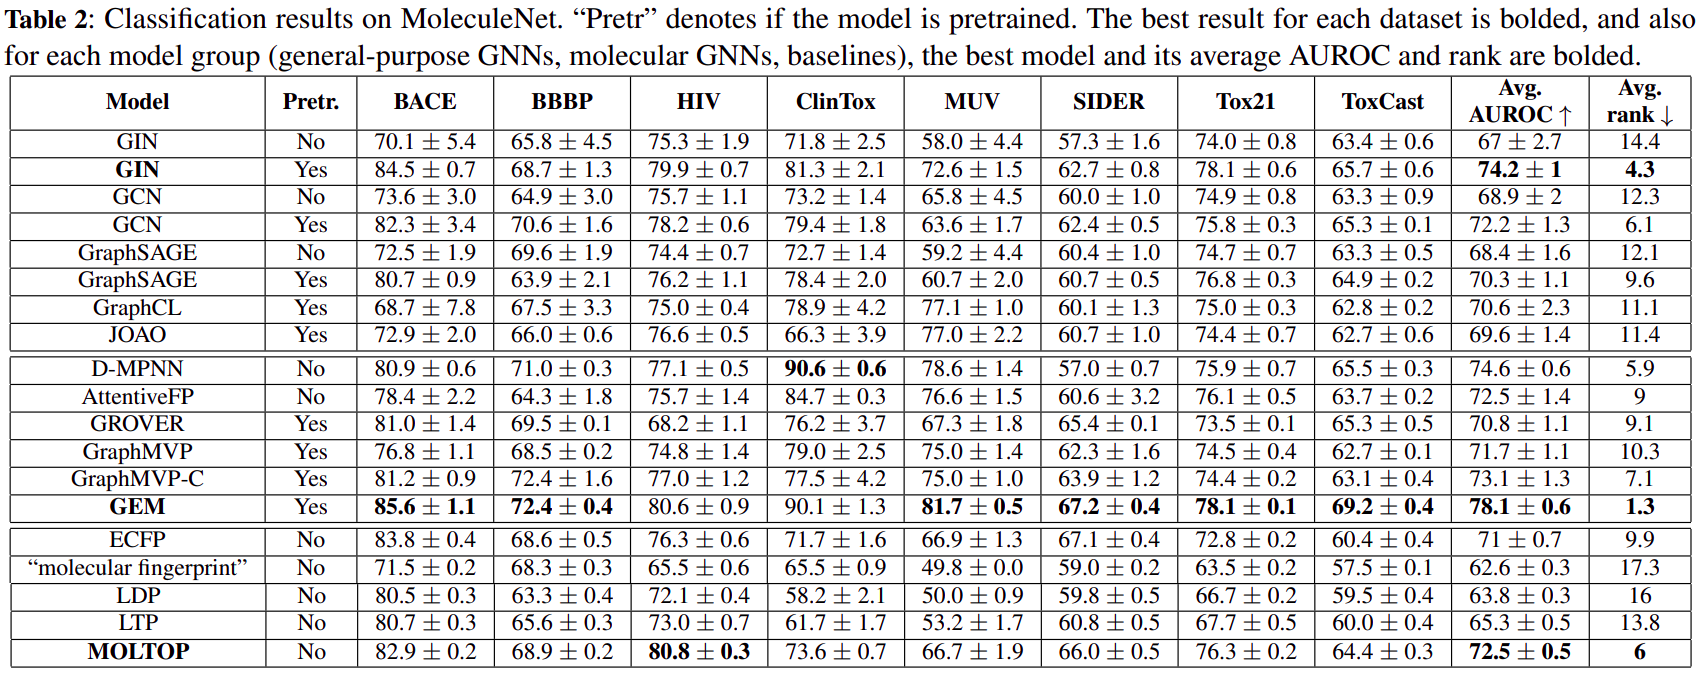